In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

Step 0: load our data

In [3]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/metadata/fully_concatenated_data.csv", lineterminator='\n')

In [ ]:
data.iloc[:, 21:35]

,TF,Category,Bio,Converted Timestamp,Year,Month,Day,Hour,Day of Week (Number),Day of Week (String),Is_English,Detected_Language,Image_Count,image_0
0,False,NaN,Rockets Fan. Red Rowdy. Rockets apparel collec...,2016-10-06 07:22:03,2016,10,6,7,3,Thursday,True,en,1,0.483804
1,False,NaN,Rockets Fan. Red Rowdy. Rockets apparel collec...,2017-12-10 20:47:00,2017,12,10,20,6,Sunday,True,en,1,1.257535
2,False,NaN,Rockets Fan. Red Rowdy. Rockets apparel collec...,2018-04-29 15:10:32,2018,4,29,15,6,Sunday,True,en,1,1.015909
3,False,NaN,Rockets Fan. Red Rowdy. Rockets apparel collec...,2018-05-02 18:48:40,2018,5,2,18,2,Wednesday,True,en,7,0.612580
4,False,NaN,Rockets Fan. Red Rowdy. Rockets apparel collec...,2018-10-27 19:26:48,2018,10,27,19,5,Saturday,True,en,1,0.961807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196174,True,Creators & Celebrities,Writer // Content creator 💭 ✉️ Enquiries: zoe@...,2018-01-10 11:31:52,2018,1,10,11,2,Wednesday,True,en,2,0.160993
196175,True,Creators & Celebrities,Writer // Content creator 💭 ✉️ Enquiries: zoe@...,2018-01-18 17:04:18,2018,1,18,17,3,Thursday,True,en,1,0.337574
196176,True,Creators & Celebrities,Writer // Content creator 💭 ✉️ Enquiries: zoe@...,2018-12-03 09:18:47,2018,12,3,9,0,Monday,True,en,1,0.860733
196177,True,Creators & Celebrities,Interior | Home | Lifestyle | Germany ▫️some m...,2018-02-18 08:25:47,2018,2,18,8,6,Sunday,False,de,1,0.039804


In [4]:
# List of image and text feature columns to keep
image_columns = [f'image_{i}' for i in range(0, 2049)]
text_columns = [f'text_{i}' for i in range(0, 768)]

# Additional columns you want to keep
additional_columns_to_keep = ['like_count', 'comment_count', 'post_id', 'Followers', 'Username', 'Followees', 'Posts',
                              'Month', 'Day of Week (String)', 'Hour', 'Language', 'Is_English', 'Image_Count', 'Sponsorship label', 'is_video', 'Image_Count']

# Combine both lists of columns to keep
columns_to_keep = additional_columns_to_keep + text_columns + image_columns

# Drop all columns except those specified in columns_to_keep
columns_to_drop = [col for col in data.columns if col not in columns_to_keep]

# Drop the unwanted columns from the dataframe
data_2 = data.drop(columns=columns_to_drop)


# Maybe don't delete category and detected languages
# Same with comments disabled and video
# potential columns to add or not:
#'comments_disabled',
#'is_video'
# Category
data_2.head(10)

# Filter image count to 10 or less, which is what is realistic in the industry
data_2 = data_2[data_2['Image_Count'] <= 1]

In [5]:
# Columns to one-hot encode
columns_to_encode = [ 'Month', 'Hour', 'Day of Week (String)']

# Apply one-hot encoding
data_2 = pd.get_dummies(data_2, columns=columns_to_encode)

# Find the new one-hot encoded columns
encoded_columns = data_2.columns[data_2.columns.str.startswith(tuple(columns_to_encode))]

# Convert only the new one-hot encoded columns and boolean columns to int
data_2[encoded_columns] = data_2[encoded_columns].astype(int)

# Convert English column to integer
data_2['Is_English'] = data_2['Is_English'].astype(int)
data_2['is_video'] = data_2['is_video'].astype(int)
data_2['Sponsorship label'] = data_2['Sponsorship label'].astype(int)

Step 1: group and split the data by post_id

Define a popularity variable

In [6]:
# Set the engagement rate variable
data_2['popularity'] = (((data_2['like_count'] + data_2['comment_count'])/data_2['Followers']))

Let's split the data!

In [7]:
# Define the number of iterations and an array to store accuracies
n_iterations = 1
accuracies = []

for seed in range(n_iterations):
    print(f"Iteration {seed+1}")

    # Split users into training and temporary sets with a new seed each time
    train_users, temp_users = train_test_split(data_2['Username'].unique(), test_size=0.2, random_state=seed)
    val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=seed)

    # Assign posts to training, validation, and test sets
    train_data = data_2[data_2['Username'].isin(train_users)]
    val_data = data_2[data_2['Username'].isin(val_users)]
    test_data = data_2[data_2['Username'].isin(test_users)]

    # Normalize the selected features
    columns_to_normalize = ['Followers', 'Followees', 'Posts']
    scaler = StandardScaler().fit(train_data[columns_to_normalize])
    train_data.loc[:, columns_to_normalize] = scaler.transform(train_data[columns_to_normalize])
    val_data.loc[:, columns_to_normalize] = scaler.transform(val_data[columns_to_normalize])
    test_data.loc[:, columns_to_normalize] = scaler.transform(test_data[columns_to_normalize])

    # Calculate the median popularity rate for each dataset
    median_popularity_rate_train = train_data['popularity'].quantile(0.5)
    train_data.loc[:, 'popularity'] = (train_data['popularity'] > median_popularity_rate_train).astype(int)
    median_popularity_rate_val = val_data['popularity'].quantile(0.5)
    val_data.loc[:, 'popularity'] = (val_data['popularity'] > median_popularity_rate_val).astype(int)
    median_popularity_rate_test = test_data['popularity'].quantile(0.5)
    test_data.loc[:, 'popularity'] = (test_data['popularity'] > median_popularity_rate_test).astype(int)

    # Prepare data for XGBoost
    X_train = train_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count'], axis=1)
    y_train = train_data['popularity']
    X_val = val_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count'], axis=1)
    y_val = val_data['popularity']
    X_test = test_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count'], axis=1)
    y_test = test_data['popularity']

    # Convert datasets to LightGBM dataset format
    train_data_lgb = lgb.Dataset(X_train, label=y_train)
    val_data_lgb = lgb.Dataset(X_val, label=y_val)
    test_data_lgb = lgb.Dataset(X_test, label=y_test)

    # Define XGBoost model parameters
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'alpha': 0.9,
        'learning_rate': 0.1
    }

    # Train the model
    # Train the LightGBM model
    bst = lgb.train(params,
                  train_data_lgb,
                  valid_sets=[train_data_lgb, val_data_lgb, test_data_lgb],
                  callbacks = [lgb.early_stopping(stopping_rounds=25)],
                  num_boost_round=1000)

    # Evaluate the model on the test set
    y_pred_prob = bst.predict(X_test)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    accuracies.append(accuracy)

    print(f"Accuracy for iteration {seed+1}: {accuracy:.2f}")

# Calculate the average accuracy across all iterations
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy across {n_iterations} iterations: {average_accuracy:.2f}")

Iteration 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 53447, number of negative: 53447
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.493529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 718935
[LightGBM] [Info] Number of data points in the train set: 106894, number of used features: 2864
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[73]	training's binary_error: 0.27444	valid_1's binary_error: 0.321365	valid_2's binary_error: 0.322428
Accuracy for iteration 1: 0.68
Average Accuracy across 1 iterations: 0.68


In [8]:
# Alternatively, using numpy to generate bootstrap samples and calculate the percentiles
# Determine the size of the accuracies array
n = len(accuracies)
bootstrap_samples = np.random.choice(accuracies, (10000, n), replace=True)
ci_lower = np.percentile(bootstrap_samples, 2.5)
ci_upper = np.percentile(bootstrap_samples, 97.5)

print(f"Bootstrap 95% Confidence Interval: {ci_lower:.5f} - {ci_upper:.5f}")

Bootstrap 95% Confidence Interval: 0.67757 - 0.67757


[0.76946575 0.4526999  0.51204205 ... 0.42277642 0.64698575 0.23298141]


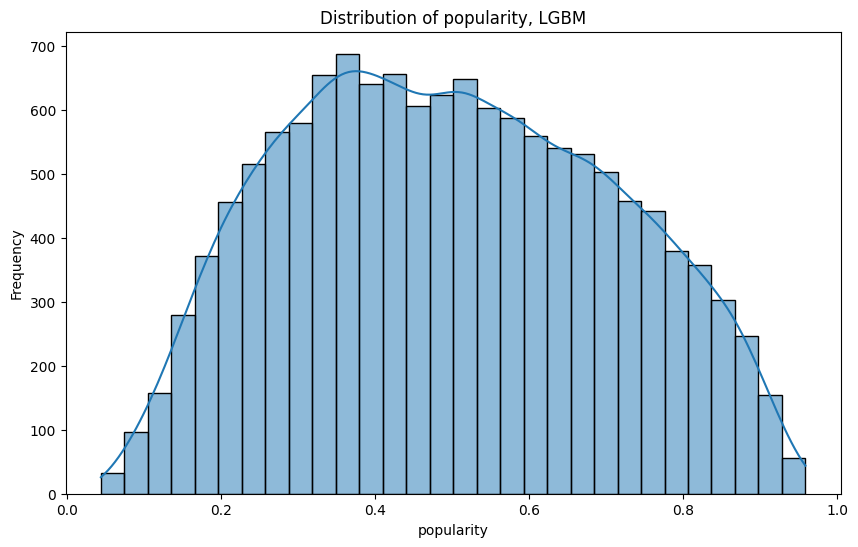

In [ ]:
y_pred = bst.predict(X_test)
print(y_pred)

plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=30, kde=True)
plt.title('Distribution of popularity, LGBM')
plt.xlabel('popularity')
plt.ylabel('Frequency')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/LGBM_predicted_popularity_value.png')  # Saving the plot
plt.show()

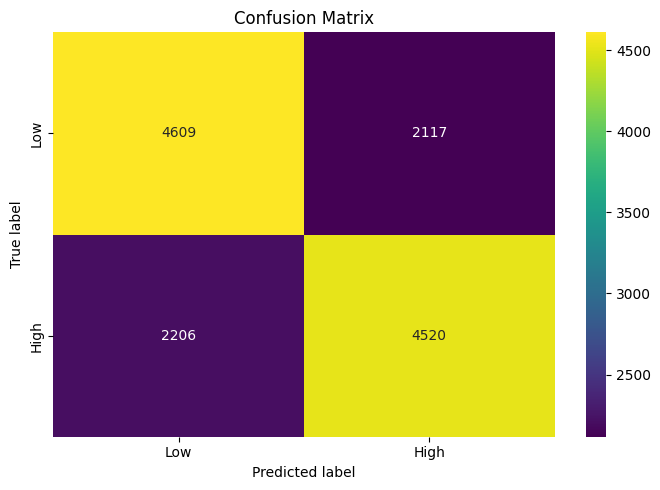

              precision    recall  f1-score   support

         Low       0.68      0.69      0.68      6726
        High       0.68      0.67      0.68      6726

    accuracy                           0.68     13452
   macro avg       0.68      0.68      0.68     13452
weighted avg       0.68      0.68      0.68     13452



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, type_of_model):
    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(X_test)
    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print the classification report
    print(clr)

# Example usage
evaluate_model(bst, X_val, val_data['popularity'], 'LightGBM')

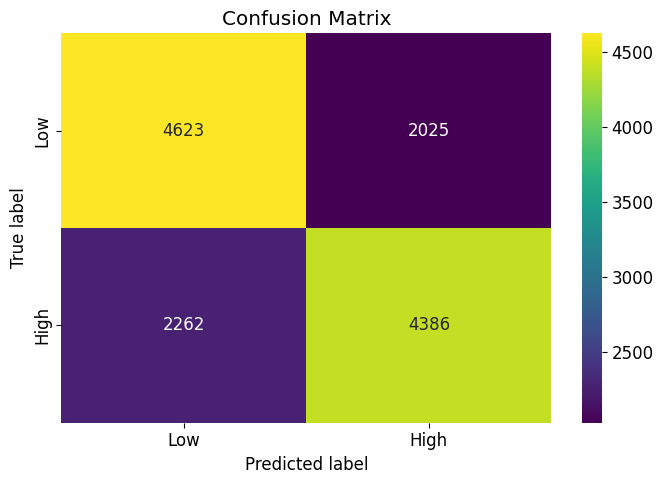

              precision    recall  f1-score   support

         Low       0.67      0.70      0.68      6648
        High       0.68      0.66      0.67      6648

    accuracy                           0.68     13296
   macro avg       0.68      0.68      0.68     13296
weighted avg       0.68      0.68      0.68     13296



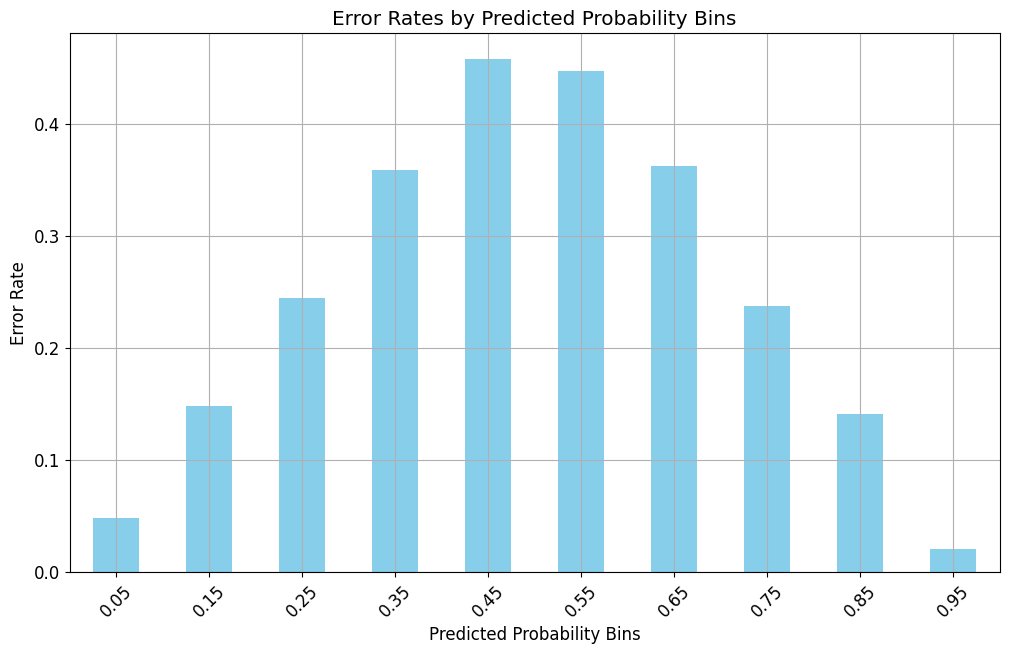

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_and_error_rates(model, X_test, y_test):
    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(X_test)

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/LGBM_confusion_matrix.png')  # Saving the plot
    plt.show()

    # Print the classification report
    print(clr)

    # Calculate error rates by probability bins
    results = pd.DataFrame({
        'y_true': y_true,
        'y_pred_prob': y_pred_prob
    })

    results['prob_bin'] = pd.cut(results['y_pred_prob'], bins=np.arange(0, 1.1, 0.1), labels=np.arange(0.05, 1.05, 0.1))

    # Calculate error rates
    error_rates = results.groupby('prob_bin').apply(
        lambda x: np.mean(x['y_true'] != (x['y_pred_prob'] > 0.5))
    )

    # Plotting error rates by predicted probability bins
    plt.figure(figsize=(12, 7))
    error_rates.plot(kind='bar', color='skyblue')
    plt.title('Error Rates by Predicted Probability Bins')
    plt.xlabel('Predicted Probability Bins')
    plt.ylabel('Error Rate')
    # Set custom labels for x-axis with two decimal precision
    plt.xticks(ticks=np.arange(len(error_rates)), labels=[f'{float(label):.2f}' for label in error_rates.index], rotation=45)
    plt.grid(True)
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/LGBM_error_rates_by_prob_bins.png')  # Saving the plot
    plt.show()

# Example usage
evaluate_model_and_error_rates(bst, X_test, test_data['popularity'])

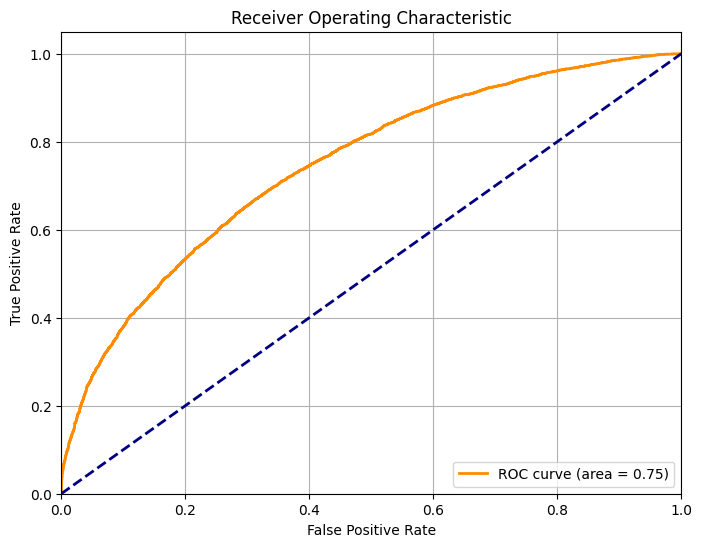

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def evaluate_model_and_plot_roc(model, X_test, y_test):
    # Predict probabilities for the test set
    # Note: Modify this line if your model's method for prediction differs
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_test)

    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)

    # Saving the ROC curve plot
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/Model_ROC_Curve_LGBM.png')
    plt.show()

# Example usage assuming 'model' is already fitted and 'X_test', 'y_test' are prepared
evaluate_model_and_plot_roc(bst, X_test, y_test)


Let's add some SHAP values!

In [10]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.2 MB/s eta 0:00:00


In [ ]:
import shap  # Import SHAP library
import matplotlib.pyplot as plt

# Assuming you have trained your model bst and have X_test ready
# Create a SHAP explainer object for a tree-based model
explainer = shap.TreeExplainer(bst)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation
shap.initjs()
fig, ax = plt.subplots()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :], matplotlib=True, show=False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/LGBM_force_plot.png')
plt.close(fig)

# Visualize the summary of SHAP values for all features across all data points with a bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/LGBM_summary_bar_plot.png')
plt.close()

# Visualize the summary of SHAP values for all features across all data points with a dot plot
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/LGBM_summary_dot_plot.png')
plt.close()

# Visualize the decision plot for a subset of data points
shap.decision_plot(explainer.expected_value, shap_values[:100, :], X_test.iloc[:100, :], show=False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/LGBM_decision_plot.png')
plt.close()


/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [ ]:
import shap  # Import SHAP library
import matplotlib.pyplot as plt

# Assuming you have trained your model bst and have X_test ready
# Create a SHAP explainer object for a tree-based model
explainer = shap.TreeExplainer(bst)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation
shap.initjs()
fig, ax = plt.subplots()

# Round the feature values in the instance to 2 decimal places for display
X_display = X_test.iloc[0, :].apply(lambda x: round(x, 2))

shap.force_plot(explainer.expected_value, shap_values[0, :], X_display, matplotlib=True, show=False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/LGBM_force_plot.png')
plt.close(fig)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [ ]:
import shap  # Import SHAP library
import matplotlib.pyplot as plt

# Assuming you have trained your model bst and have X_test ready
# Create a SHAP explainer object for a tree-based model
explainer = shap.TreeExplainer(bst)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Set up the figure size and font size for better readability
plt.figure(figsize=(12, 10))  # Use an even larger figure size if needed
plt.rcParams.update({'font.size': 12})  # Ensure the font size is large enough for readability

# Visualize the summary of SHAP values for all features across all data points with a bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('Feature Importance Based on SHAP Values', fontsize=14, pad=20)  # Adjust the title size and padding

# Adjust subplot to ensure all text fits within the figure
plt.gcf().subplots_adjust(left=0.3, right=1.2, top=0.9, bottom=0.2)  # Adjust bottom margin to fit x-axis labels

# Save the improved plot with bounding box tight to include all elements
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/LGBM_feature_importance_final.png', bbox_inches='tight')
plt.close()

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


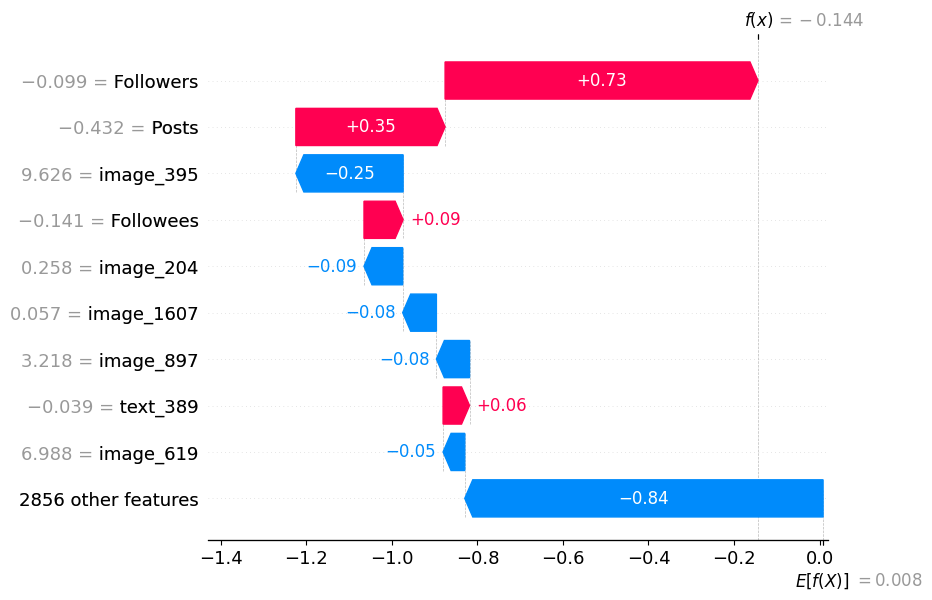

<Figure size 640x480 with 0 Axes>

In [18]:
import xgboost
import shap

# Calculate SHAP values for the test data
explainer = shap.Explainer(bst)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[555])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/watefall_SHAP_LGBM_555.png')

In [30]:
import xgboost
import shap
import matplotlib.pyplot as plt  # Ensure matplotlib is imported

# Calculate SHAP values for the test data
explainer = shap.Explainer(bst)
shap_values = explainer(X_test)

# Visualize the first prediction's explanation
fig, ax = plt.subplots(figsize=(12, 8))  # Increase the figure size for better layout
shap.plots.waterfall(shap_values[555], show=False)  # Generate SHAP plot on this axis

# Use tight layout to automatically adjust plot elements
plt.tight_layout()

# Save the figure with adjusted bounding box and padding
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/watefall_SHAP_LGBM_555.jpg',
            bbox_inches='tight', pad_inches=0.1)  # Add padding to ensure no clipping of text
plt.close(fig)  # Close the figure to free memory